# **Image Classification with the CIFAR-10 Dataset**

In this notebook, the [ConvNeXt V2 Large](https://huggingface.co/facebook/convnextv2-large-22k-384) model is fine-tuned using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for the image classification task. This dataset contains 60,000 RGB images, with 50,000 images designated for training and 10,000 for testing, distributed across 10 different classes.

The [ConvNeXt V2](https://huggingface.co/docs/transformers/model_doc/convnextv2) model is a pure convolutional neural network, pretrained using the FCMAE (Fully Convolutional Masked Autoencoder) framework. This framework is a convolutional-based approach for masked autoencoders (MAE), a mechanism typically using Transformer architectures. In MAE, a significant portion of the input (images) is masked during training, and the model learns to reconstruct the missing parts from the visible information, forcing the model to capture robust and generalizable features.

Additionally, ConvNeXt V2 introduces an extra layer called Global Response Normalization (GRN) to the original [ConvNeXt](https://huggingface.co/docs/transformers/model_doc/convnext) architecture. This layer helps improve the consistency and stability of the model's output by normalizing the response of neurons across the entire image, allowing for better generalization in complex computer vision tasks. The model has been fine-tuned with the [ImageNet-22K](https://www.image-net.org/) dataset at a resolution of 384x384 pixels, providing a solid foundation for high-precision classification tasks.


## **Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import AutoImageProcessor, TFAutoModelForImageClassification
from transformers import create_optimizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [9]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
epochs = 5
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
model_name = "facebook/convnextv2-large-22k-384"

## **Prepare the dataset for training**

### **Load the dataset**

In [29]:
(train_dataset, test_dataset), info = tfds.load("cifar10", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learni

In [5]:
num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
class_names = [name.capitalize() for name in class_names]

print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 10
Class names: ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


### **Preprocessing and data augmentation**

To combat overfitting, it is crucial to use data augmentation techniques, especially given that the training dataset is relatively small. Data augmentation will enhance the model's generalization capability for image classification. To achieve this, TensorFlow layers such as [``RandomFlip``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [``RandomTranslation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation), [``RandomRotation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation), and [``RandomZoom``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) will be used. These layers should only be applied to the training dataset during preprocessing, which is controlled by setting the parameter ``training=True``.

Regarding image preprocessing, the generic image processor class from Hugging Face, [AutoImageProcessor](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoImageProcessor), could be used, but it is not compatible with TensorFlow graphs, which would slow down training. Therefore, TensorFlow layers will be used for preprocessing, allowing the processing to be applied in parallel with training, significantly speeding up the training time. The [``Resizing``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) layer will be used to resize the images and make them compatible with the model, the [``Rescaling``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer to normalize the images in the range of ``[-1;1]``, and the [``Permute``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Permute) layer to rearrange the image channels into the second dimension, ensuring compatibility with the PyTorch model format. These three layers operate independently of the ``training`` parameter, so they are applied to both the training and testing datasets.

In [6]:
image_processor = AutoImageProcessor.from_pretrained(model_name)
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 384
  }
}

In [8]:
original_size = info.features["image"].shape
new_size = (image_processor.size["shortest_edge"], image_processor.size["shortest_edge"], 3)

original_size, new_size

((32, 32, 3), (384, 384, 3))

In [9]:
def function_data_augmentation(input_shape, output_shape):
  return tf.keras.Sequential([
      tf.keras.Input(shape=input_shape),
      tf.keras.layers.Resizing(output_shape[0], output_shape[1]),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
      tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
      tf.keras.layers.RandomZoom(0.2, fill_mode="nearest"),
      tf.keras.layers.Rescaling(1/127.5, offset=-1),
      tf.keras.layers.Permute((3, 1, 2))
  ], name="data_augmentation")

In [10]:
tf.keras.backend.clear_session() #Clearing Keras memory

data_augmentation = function_data_augmentation(original_size, new_size)
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 384, 384, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 384, 384, 3)       0         
                                                                 
 random_translation (Random  (None, 384, 384, 3)       0         
 Translation)                                                    
                                                                 
 random_rotation (RandomRot  (None, 384, 384, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 384, 384, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 384, 384, 3) 

In [11]:
def prepare_dataset(dataset, training=True):
  if training:
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      batch(batch_size).
      map(lambda x, y : (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE).
      prefetch(AUTOTUNE)
  )

  return dataset

In [12]:
train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset, training=False)

In [ ]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(128, 3, 384, 384) (128,)


(-1.0, 1.0)

**Function to display and save images**

In [13]:
def show_images(images, labels, predictions=None, num_examples=36, random=True,
                cmap=None, axis="off", save=False, path=""):

  # Denormalize the images
  images = (tf.transpose(images, perm=[0, 2, 3, 1]) + 1) / 2

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.25*n, 1.25*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"

      ax.text(
          x=0.5, y=1.11, s=f"Label: {class_names[labels[indices[i]]]}", color=color, fontsize=6.6,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=1, s=f"Pred: {class_names[predictions[indices[i]]]}", color=color, fontsize=6.6,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {class_names[labels[indices[i]]]}", fontsize=6.6,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path)

  plt.show()

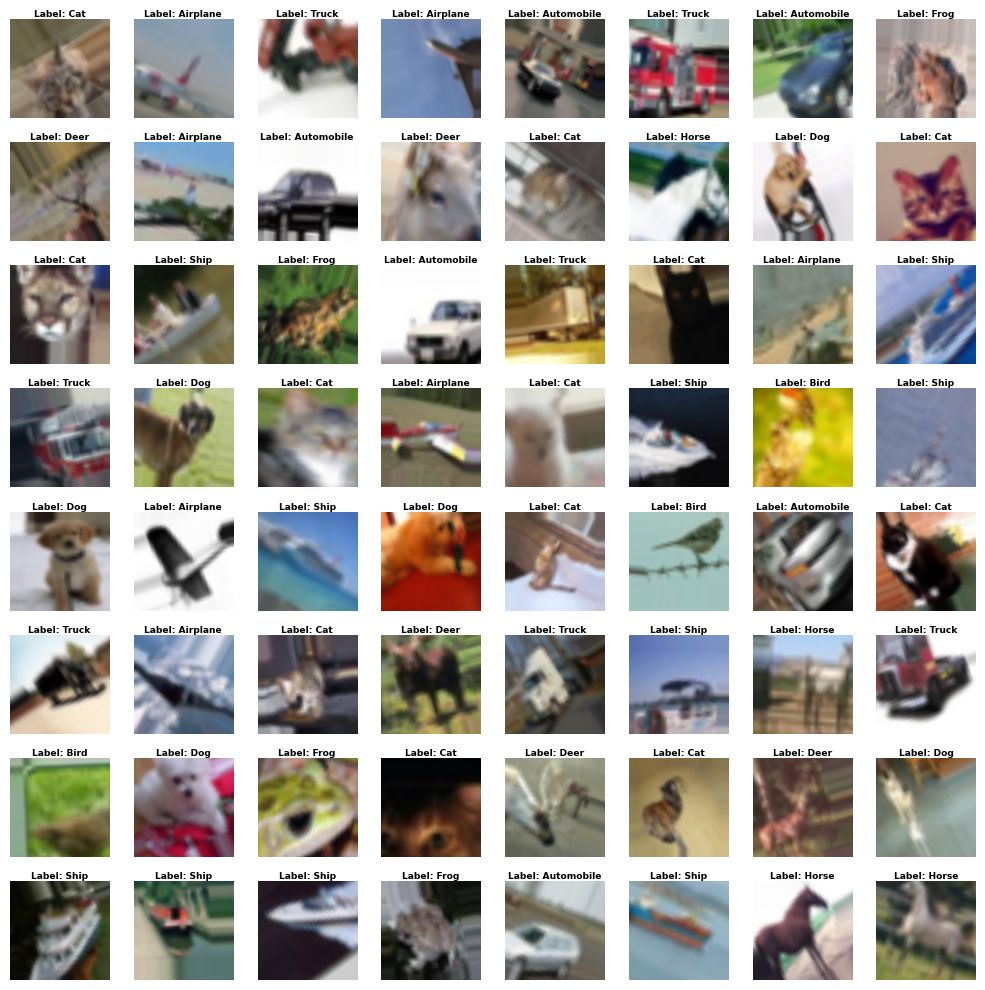

In [ ]:
# Some images from the training dataset after data augmentation
show_images(images, labels, random=False, num_examples=64)

## **Model building and training**

To speed up the training time, Google's Colab TPU is used due to the large size of the model, which has about 200 million parameters. The model is loaded using the generic class [TFAutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which allows for the loading of a ViT model available on Hugging Face by specifying only its name.

In [14]:
# TPU setup

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
tf.keras.backend.clear_session()

with strategy.scope():
  model = TFAutoModelForImageClassification.from_pretrained(
      model_name,
      num_labels=num_classes,
      ignore_mismatched_sizes=True
  )

  optimizer, lr_schedule = create_optimizer(
      init_lr=3e-5,
      num_train_steps=len(train_dataset)*epochs,
      weight_decay_rate=0.01,
      num_warmup_steps=0
  )
  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
      steps_per_execution=50
  )

model.summary()

All model checkpoint layers were used when initializing TFConvNextV2ForImageClassification.

Some weights of TFConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-large-22k-384 and are newly initialized because the shapes did not match:
- classifier/kernel:0: found shape (1536, 1000) in the checkpoint and (1536, 10) in the model instantiated
- classifier/bias:0: found shape (1000,) in the checkpoint and (10,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_conv_next_v2_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnextv2 (TFConvNextV2Ma  multiple                  196419840 
 inLayer)                                                        
                                                                 
 classifier (Dense)          multiple                  15370     
                                                                 
Total params: 196435210 (749.34 MB)
Trainable params: 196435210 (749.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Callback to stop training early if validation accuracy does not improve for 1 epoch
patience = 1
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=patience,
    restore_best_weights=True
)

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/5
391/391 [==============================] - 1004s 3s/step - loss: 0.1580 - accuracy: 0.9572 - val_loss: 0.0340 - val_accuracy: 0.9890
Epoch 2/5
391/391 [==============================] - 570s 1s/step - loss: 0.0328 - accuracy: 0.9900 - val_loss: 0.0292 - val_accuracy: 0.9908
Epoch 3/5
391/391 [==============================] - 571s 1s/step - loss: 0.0194 - accuracy: 0.9940 - val_loss: 0.0257 - val_accuracy: 0.9928
Epoch 4/5
391/391 [==============================] - 570s 1s/step - loss: 0.0127 - accuracy: 0.9962 - val_loss: 0.0253 - val_accuracy: 0.9929
Epoch 5/5
391/391 [==============================] - 570s 1s/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0243 - val_accuracy: 0.9932


**Save the model**

In [15]:
trained_model_path = "/content/drive/MyDrive/models/ImageClassification_ConvNeXTV2_CIFAR-10"
model.save_pretrained(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.006663771811872721, 0.9980599880218506]
[0.024338888004422188, 0.9932000041007996]


### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.8 MB/s eta 0:00:00


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history.history, metric="loss", renderer=None, with_patience=False):
  epochs = len(history["loss"])
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

  last_epoch = epochs-patience if with_patience else epochs
  fig.add_vline(
      x=last_epoch, line=dict(color="red", width=2, dash="dash"),
      annotation_text="End of Training", annotation_position="top left",
      annotation=dict(font_size=12, font_color="red")
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(metric="accuracy")
plot_metrics()

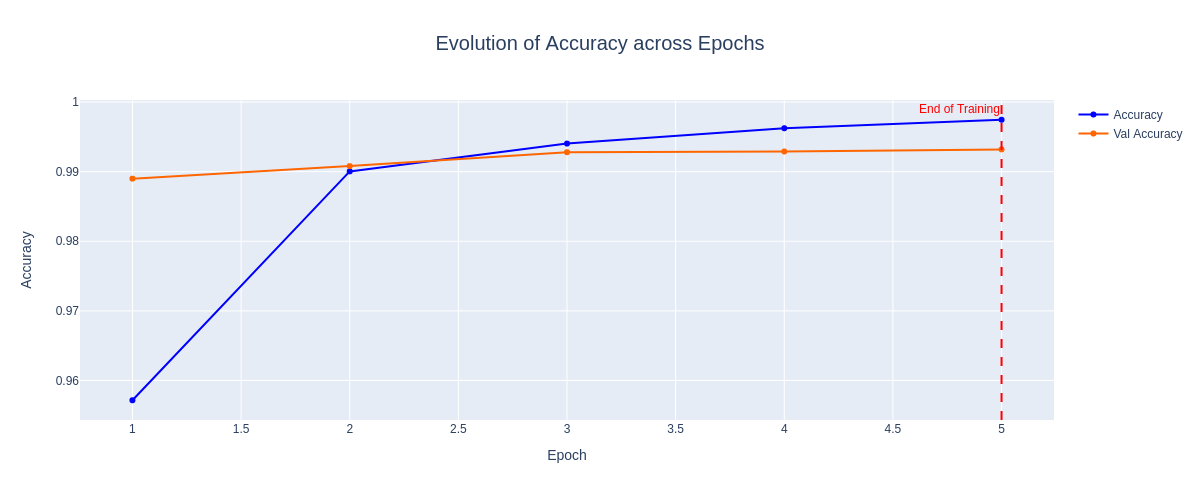

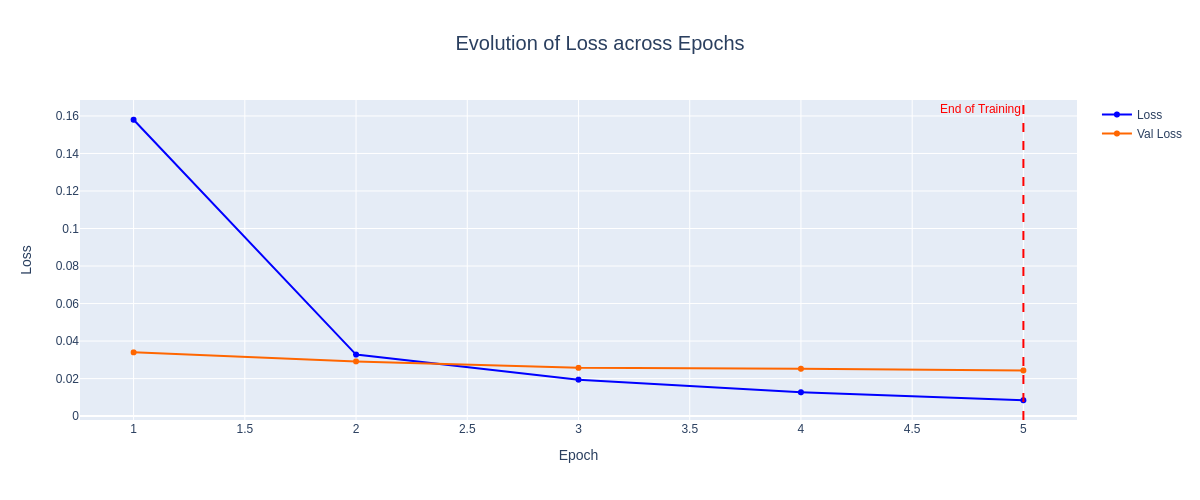

In [ ]:
# Static image for GitHub
plot_metrics(metric="accuracy", renderer="png")
plot_metrics(renderer="png")

### **Confusion Matrix**

In [17]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0).logits
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

# Consolidating the accuracy of the test dataset
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred, average='macro')}")

Accuracy: 0.9932
F1 Score: 0.9931987935225136


Frequency per Label: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000] 



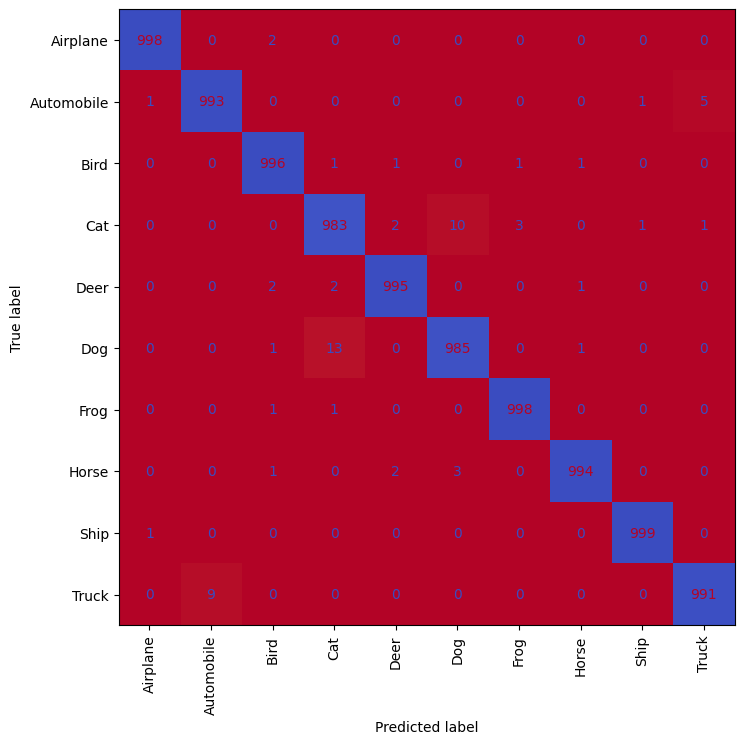

In [18]:
print("Frequency per Label:", np.unique(labels_test, return_counts=True)[1], "\n")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical");

The test dataset is balanced, with 1,000 images per label. The confusion matrix shows that the model distinguishes the classes quite well, as most of the elements outside the main diagonal of the matrix are zero. However, the model has a slight difficulty differentiating between the ``cat`` and ``dog`` classes, which are the most challenging. On the other hand, it nearly classified all 1,000 images of the ``ship`` class correctly, making only one error.

## **Predictions with the trained model**

### **Test dataset**

In [19]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))

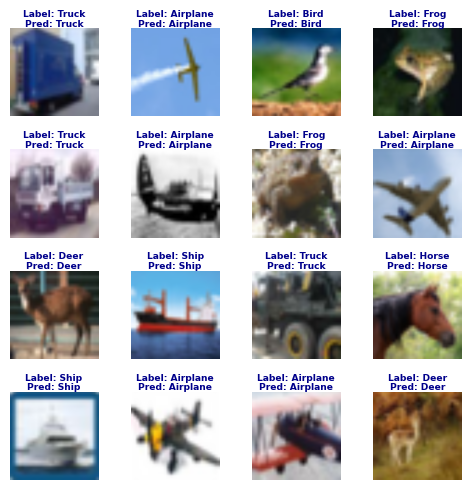

In [20]:
show_images(images_test, labels_test, labels_test_pred, num_examples=16)

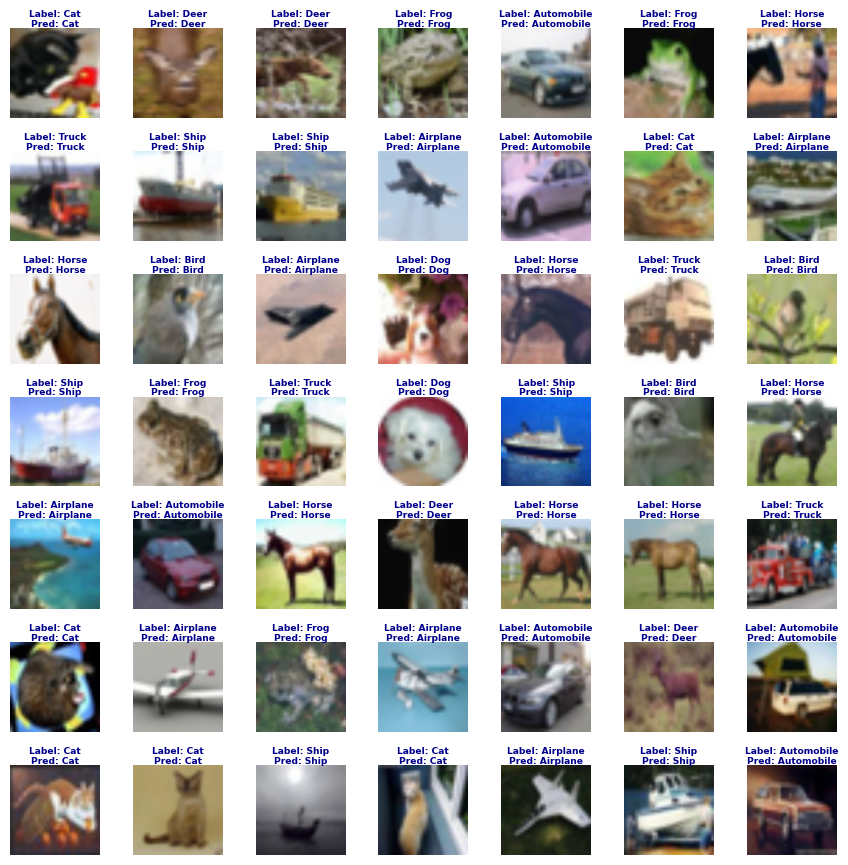

In [25]:
show_images(
    images_test, labels_test, labels_test_pred, save=True,
    num_examples=49, path="ImageClassification_ConvNeXTV2_CIFAR-10.png"
)

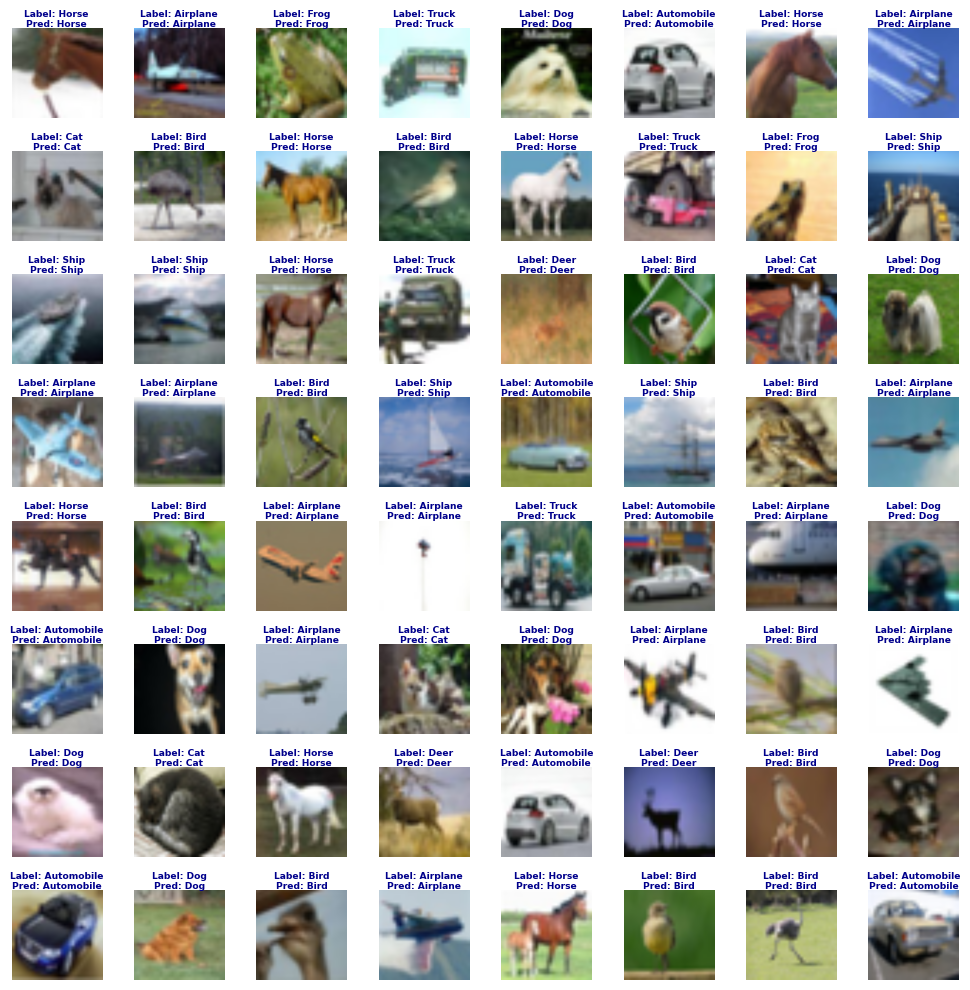

In [22]:
show_images(images_test, labels_test, labels_test_pred, num_examples=64, random=False)

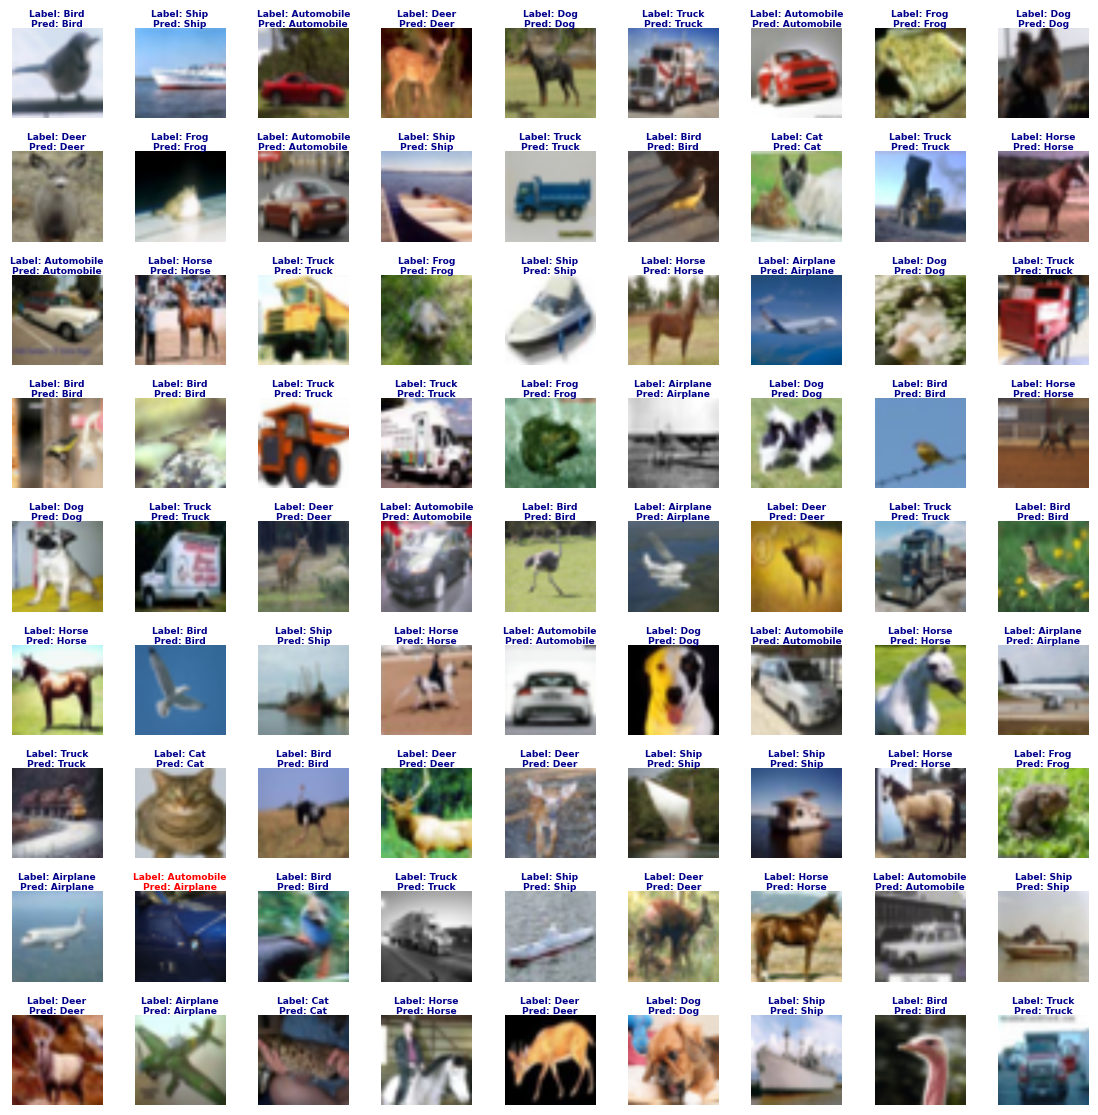

In [28]:
# This image shows an incorrect prediction
show_images(images_test, labels_test, labels_test_pred, num_examples=81)

### **Other images**

In [10]:
# Load the trained model
tf.keras.backend.clear_session()
model = TFAutoModelForImageClassification.from_pretrained(trained_model_path)

All model checkpoint layers were used when initializing TFConvNextV2ForImageClassification.

All the layers of TFConvNextV2ForImageClassification were initialized from the model checkpoint at /content/drive/MyDrive/models/ImageClassification_ConvNeXTV2_CIFAR-10.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFConvNextV2ForImageClassification for predictions without further training.


In [11]:
# Function to predict images from the internet
def predict_image(url, label=None):
  path = tf.keras.utils.get_file(origin=url)
  image = tf.keras.utils.load_img(path)
  inputs = image_processor(image, return_tensors="tf")

  pred = model(**inputs).logits
  pred = np.argmax(pred, axis=-1)
  pred = class_names[pred[0]]

  if label is not None:
    color = "#00008B" if label == pred else "red"
    plt.title(f"Label: {label}\nPred: {pred}", color=color)
  else:
    plt.title(f"Pred: {pred}")

  plt.imshow(image)
  plt.axis("off")
  plt.tight_layout();

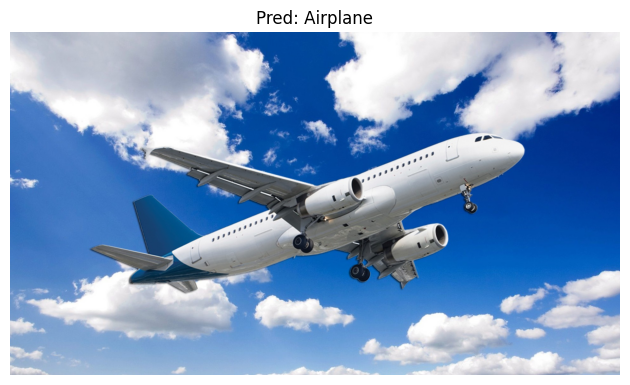

In [22]:
url = "https://www.baltana.com/files/wallpapers-13/Airplane-HD-Wallpapers-34421.jpg"
#label = "Airplane"

predict_image(url)

722785/722785 [==============================] - 0s 0us/step


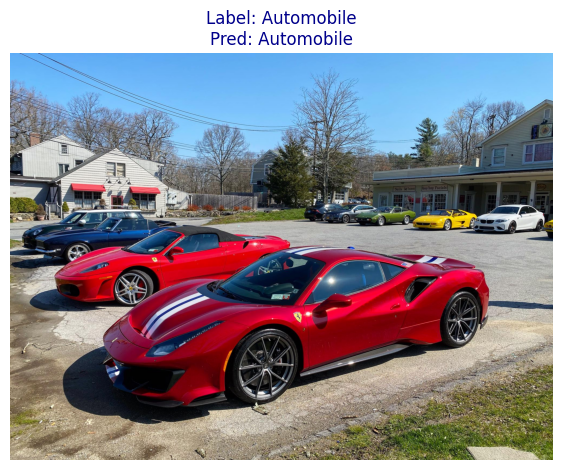

In [27]:
url = "https://rossoautomobili.com/cdn/shop/articles/Rosso_Magma_Ferrari_488_Pista.JPG?v=1591100355"
label = "Automobile"

predict_image(url, label)

39542/39542 [==============================] - 0s 0us/step


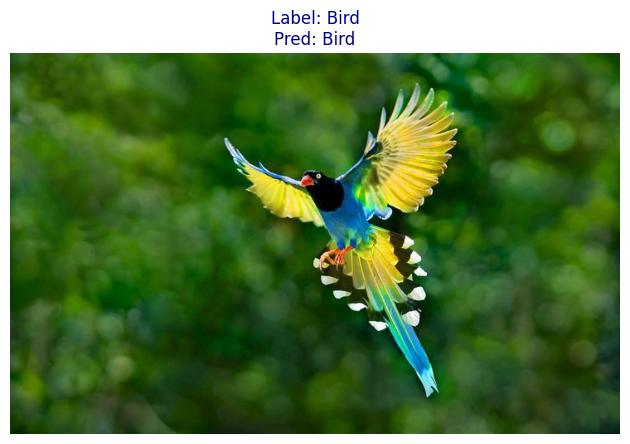

In [17]:
url = "https://i.pinimg.com/736x/d7/96/79/d796790ad719c49564c617ddf23def89.jpg"
label = "Bird"

predict_image(url, label)

44728/44728 [==============================] - 0s 0us/step


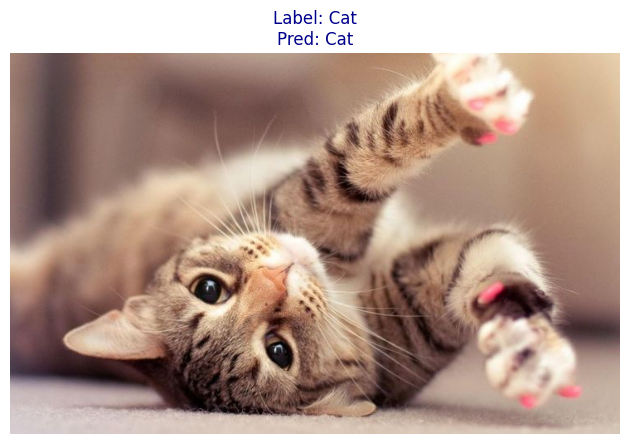

In [29]:
url = "https://i.pinimg.com/736x/70/89/03/7089033d7e5d873b61f3e03d8201ce54.jpg"
label = "Cat"

predict_image(url, label)

1488149/1488149 [==============================] - 0s 0us/step


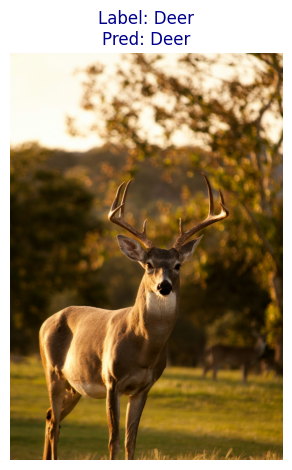

In [18]:
url = "https://images.unsplash.com/photo-1484406566174-9da000fda645?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxleHBsb3JlLWZlZWR8Mnx8fGVufDB8fHx8fA%3D%3D"
label = "Deer"

predict_image(url, label)

196347/196347 [==============================] - 0s 1us/step


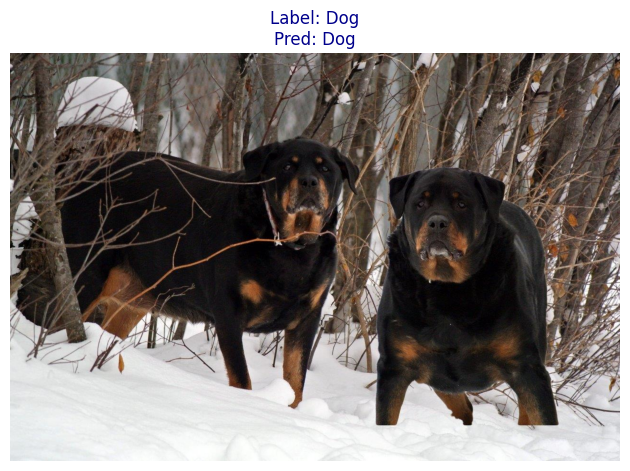

In [30]:
url = "https://www.keshetkennels.com/wp-content/uploads/2014/04/damien-emma.jpg"
label = "Dog"

predict_image(url, label)

60671/60671 [==============================] - 0s 3us/step


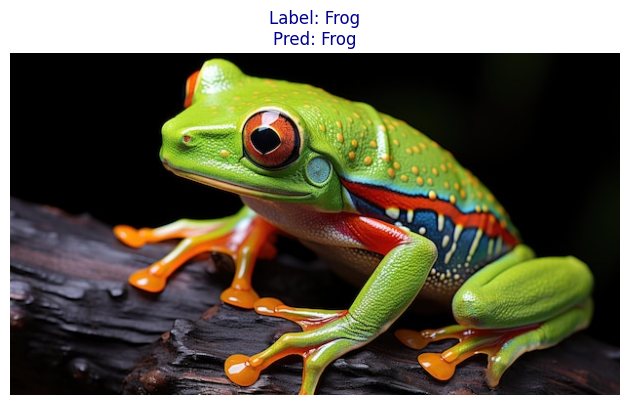

In [19]:
url = "https://img.freepik.com/premium-photo/green-frog-hd-8k-wallpaper-background-stock-photographic-image_915071-47360.jpg"
label = "Frog"

predict_image(url, label)

74269/74269 [==============================] - 0s 0us/step


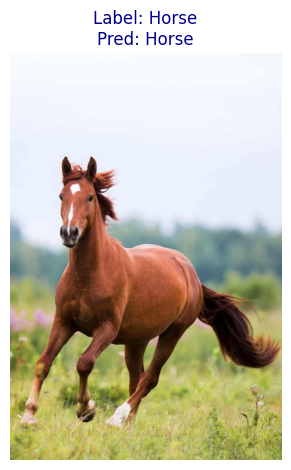

In [31]:
url = "https://i.pinimg.com/736x/50/8a/a3/508aa3a6ed83ac6e179b5ac552904b2e.jpg"
label = "Horse"

predict_image(url, label)

423085/423085 [==============================] - 0s 0us/step


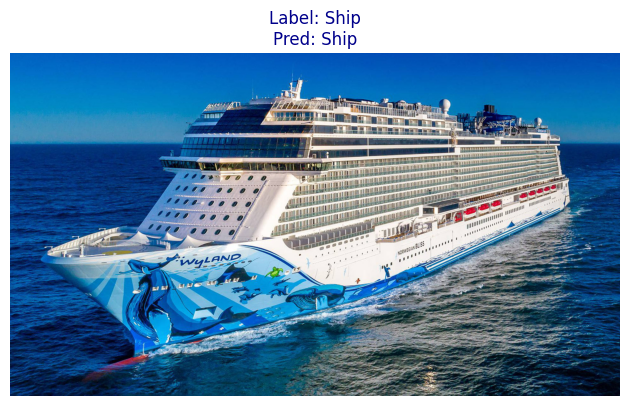

In [21]:
url = "https://wallpapers.com/images/featured/cruise-ship-48fv0tg5inbcobk9.jpg"
label = "Ship"

predict_image(url, label)

19908/19908 [==============================] - 0s 0us/step


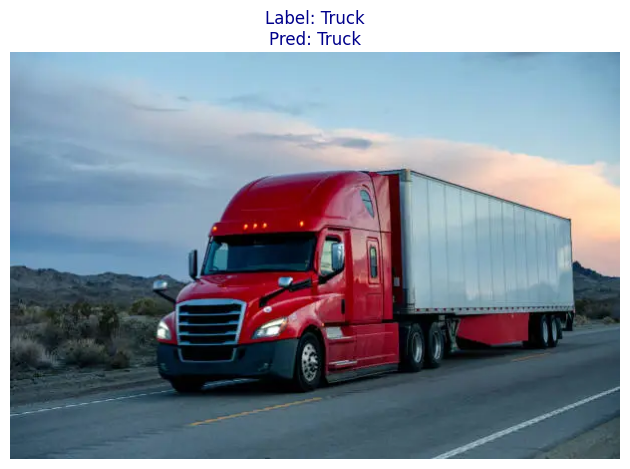

In [32]:
url = "https://media.istockphoto.com/id/1475929281/photo/a-red-semi-truck-on-a-two-lane-highway-with-beautiful-clouds-in-the-sky.webp?b=1&s=612x612&w=0&k=20&c=pNc8KgCeLPrlJBz6azIwozmr_RysWjQt82zo6epygvk="
label = "Truck"

predict_image(url, label)

**Conclusion:** The model achieved an accuracy of **99.81%** on the training dataset and an accuracy and F1 score of **99.32%** on the test dataset. These results indicate that the model is highly effective at classifying images belonging to the 10 classes of the CIFAR-10 dataset, showing excellent performance both on this dataset and on external images, as demonstrated earlier. The balance between precision and recall is noteworthy, given that the accuracy and F1 score are equal in the evaluation. Additionally, the absence of overfitting suggests that the data augmentation techniques and the early stopping callback were effective. If training had continued for more epochs, the training accuracy would likely have reached 100%, while the test accuracy might have started to decrease or stabilize. Achieving an accuracy above 99% on CIFAR-10 is a significant milestone, comparable to the top computer vision models currently listed on [Papers With Code](https://paperswithcode.com/sota/image-classification-on-cifar-10). This fine-tuned model, with an accuracy of **99.32%**, would rank ninth considering the test dataset, demonstrating the robustness of the ConvNeXt V2 model and the effectiveness of the fine-tuning performed in this notebook.